# Name : Tharindu O.K.D {-}
# Index No. : 190622R {-}

### Question 01 {-}

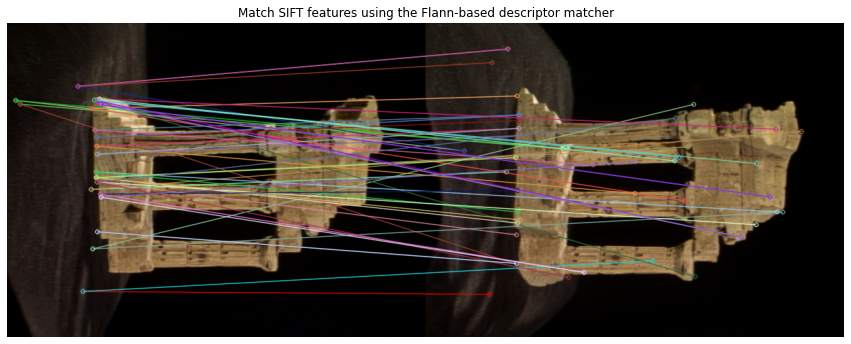

In [57]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

f = open(r'templeSR_par.txt', 'r')
assert f is not None
n = int(f.readline())

# first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# read the two images
img1 = cv.imread(im1_fn, cv.IMREAD_COLOR)
img2 = cv.imread(im2_fn, cv.IMREAD_COLOR)
assert img1 is not None
assert img2 is not None

sift = cv.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = np.array(flann.knnMatch(des1, des2, k=2))

img3 = cv.drawMatches(img1, kp1, img2, kp2, matches.flatten()[:50], img2, flags=2)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax.set_title("Match SIFT features using the Flann-based descriptor matcher")
plt.axis("off")
plt.show()


### Question 02 {-}

In [58]:
good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
print("Fundamental Matrix F \n", F)
E = K2.T @ F @ K1
print("Essential matrix E \n", E)

Fundamental Matrix F 
 [[ 1.49153162e-06  1.44167041e-05 -2.53856343e-02]
 [-8.26011598e-06  8.59978832e-08  4.01137106e-03]
 [ 2.27427962e-02 -7.28550343e-03  1.00000000e+00]]
Essential matrix E 
 [[ 3.44784859e+00  3.34464415e+01 -3.24995576e+01]
 [-1.91632903e+01  2.00234961e-01  2.34287157e+00]
 [ 3.21633644e+01 -4.43398334e+00 -6.21548416e-03]]


### Question 03 {-}

In [59]:
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)
print("Recovered R\n", R)
print("Recovered t\n", t)

Recovered R
 [[ 0.99735755 -0.06958106  0.02089014]
 [ 0.06148421  0.96160188  0.26747247]
 [-0.03869902 -0.26548127  0.96333903]]
Recovered t
 [[-0.06192405]
 [-0.86033266]
 [-0.50595763]]


### Question 04 {-}

In [60]:
R_t_1 = np.concatenate((R1, t1), axis=1)
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_, t2_), axis=1)

P1 = K1 @ np.hstack((R1, t1))
P2_ = K2 @ R_t_2
print("Recovered Camera Matrix P2\n", P2_)

Recovered Camera Matrix P2
 [[ 1.58564726e+02  1.53323553e+03 -1.64497974e+02 -9.52719771e+02]
 [ 1.53408122e+03 -1.25233589e+02 -1.42221559e+02  4.26193512e+01]
 [ 7.55549533e-02  8.27515962e-02 -9.93701979e-01  6.50118701e-01]]


### Question 05 {-}

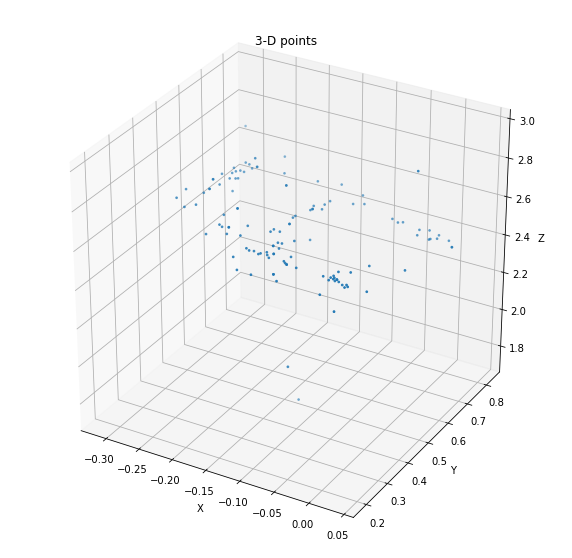

In [61]:
points4d = cv.triangulatePoints(P1, P2_, pts1.T, pts2.T)
points4d /= points4d[3, :]
X = points4d[0, :]
Y = points4d[1, :]
Z = points4d[2, :]
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=3, cmap='gray')
ax.set_title("3-D points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()